In [23]:
%matplotlib notebook
import sys
import numpy as np
import scipy.spatial.distance as dist
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
from sklearn.linear_model import LinearRegression
import h5py
import math
from scipy.stats import multivariate_normal
from scipy.stats.mstats import gmean
from scipy.integrate import dblquad
import scipy
import multiprocessing as mp
from tqdm import tqdm
from time import sleep
import psutil
import time
from scipy import ndimage

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)


### Check the system setup

In [16]:
with tqdm(total=100, desc='cpu%', position=1) as cpubar, tqdm(total=100, desc='ram%', position=0) as rambar:
#     while True:
    rambar.n=psutil.virtual_memory().percent
    cpubar.n=psutil.cpu_percent()
    rambar.refresh()
    cpubar.refresh()
    sleep(0.5)


ram%:   9%|▉         | 9.4/100 [00:00<00:00, 15657.85it/s]
ram%:   9%|▉         | 9.4/100 [00:00<00:04, 18.71it/s]   [A
cpu%:   4%|▎         | 3.5/100 [00:00<00:13,  6.95it/s]  


## 44-node Indoor Dataset Loading

In [17]:
iqfile = 'savedSig/savedSig.mat'
locfile = 'savedSig/deviceLocs.mat'
iqdic = sio.loadmat(iqfile)
nodeloc = sio.loadmat(locfile)['deviceLocs']
print(nodeloc.shape)

(44, 2)


## Raw power delay profile checking

type <class 'numpy.complex128'>
iq shape (8, 50)
time shape (1, 8)
iqdic shape (1, 1) 



<IPython.core.display.Javascript object>


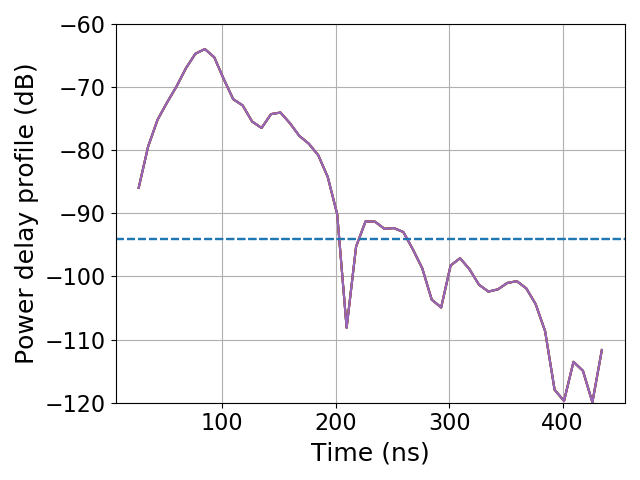

In [18]:

print('type',type(iqdic['savedSig'][0,1][0,1]))
print('iq shape',(iqdic['savedSig'][22,14]).shape)
print('time shape',iqdic['savedStartTime_ns'][22][14].shape)
print('iqdic shape',iqdic['delta_t'].shape,'\n')

plt.figure()
for i in range(len(iqdic['savedSig'][0,23])):
    time = iqdic['savedStartTime_ns'][0,23][0,0]+np.arange(0,50)*iqdic['delta_t'][0]
    plt.plot(time, 20*np.log10(abs(iqdic['savedSig'][0,23][0,:])))
    plt.xlabel('Time (ns)',fontsize=18)
    plt.ylabel('Power delay profile (dB)',fontsize=18)
    plt.axhline(-94,linestyle='--')
    plt.ylim([-120,-60])
plt.grid()
plt.tight_layout()

## Path gain/fading loss checking while considering link recirocity

len(rssRec) 946
refLoss, n_p, e_std -37.238408499029774 2.2449345289581646 19.610003872777273


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


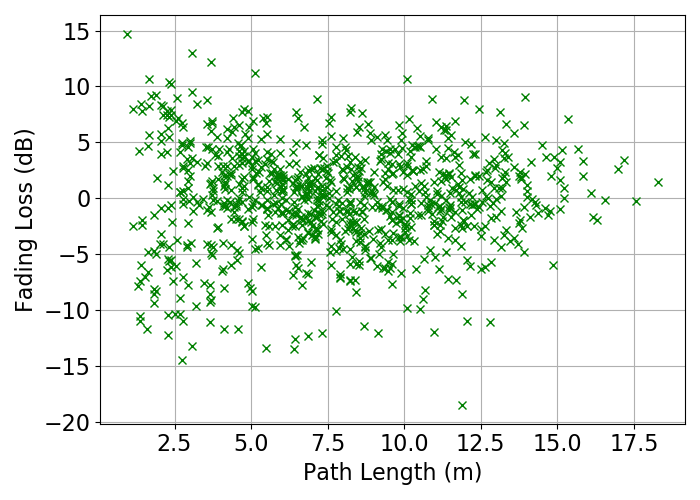

In [19]:
# expect reciprocity 44x43/2 = 946

def calDistanceArr(num_node):
    dis = np.array([])
    for i in range(num_node):
        for j in range(i+1,num_node):
            dis = np.append(dis,np.sqrt(sum((nodeloc[i,:]-nodeloc[j,:])**2)))

    return dis


def calRSS(num_node,threshold,iqdic):
    RSS = np.ones((num_node,num_node,8))
    NumEffec = np.zeros((num_node,num_node))
    for i in range(num_node):
        for j in range(num_node):
            if i==j:
                continue
                
            pdp = abs(iqdic['savedSig'][i,j])**2 # should be squared to get pdp!!!
            idThresh = pdp>threshold
            NumEffecMeas = len(idThresh)
            RSSThresh = np.array([sum(pdp[m,idThresh[m]]) for m in range(NumEffecMeas)])
            RSS[i,j,0:NumEffecMeas] = RSSThresh
            NumEffec[i,j] = NumEffecMeas
    
    rss = np.array([])
    for i in range(num_node):
        for j in range(i+1,num_node):
            RssBothDirec = np.concatenate((RSS[i,j,0:int(NumEffec[i,j])],RSS[j,i,0:int(NumEffec[j,i])]))
            rss = np.append(rss,10.0*np.log10(gmean(RssBothDirec))) #
 
    return RSS, rss

# prepare the distance and RSS vector
num_node = nodeloc.shape[0]
threshold = 10**(-94/10.0)
disRec = calDistanceArr(num_node)
RSSRec, rssRec = calRSS(num_node, threshold,iqdic)
print('len(rssRec)',len(rssRec))

# linear regression
coeffs  = np.polyfit(-10.0*np.log10(disRec), rssRec, 1)
n_p     = coeffs[0]
refLoss = coeffs[1]


RssEst = n_p*(-10.0*np.log10(disRec)) + refLoss
residuals = rssRec - RssEst
e_std   = np.sqrt(np.mean(abs(residuals)**2))
print('refLoss, n_p, e_std',refLoss, n_p, e_std**2)

PathGain = rssRec#-10-2*1.1
PathGainEst = RssEst#-10-2*1.1
plt.figure(figsize=(7,5))
plt.plot(disRec,PathGain,'rx', disRec,PathGainEst, 'b-')
plt.xscale('log')
plt.grid('on')
plt.xlabel('Path Length (m)', fontsize=16)
plt.ylabel('Path Gain (dB)', fontsize=16)
plt.tight_layout()


FadLoss = refLoss-n_p*10.0*np.log10(disRec)-rssRec
FadLoss.var()
plt.figure(figsize=(7,5))
plt.plot(disRec,FadLoss,'gx')
plt.grid('on')
plt.xlabel('Path Length (m)', fontsize=16)
plt.ylabel('Fading Loss (dB)', fontsize=16)
plt.tight_layout()


## Functions: 
### please see function *CELF* as the main _channel estimation via loss field_ algorithm.

In [34]:
# expect reciprocity num_links = int(num_nodes*(num_nodes-1)/2)

def plotLocs(nodeloc):
    '''
    Input
    -----
        nodeloc: num_nodes x 2, the 2D coordinates of the 44 nodes. 
    Function
    -----
        plot the locations of the 44 nodes.
    '''
    plt.figure()
    plt.plot(nodeloc[:,0], nodeloc[:,1], '.', markersize=14.0)

    #Increase the axes to show full map.
    xmin, xmax, ymin, ymax = plt.axis()
    deltay          = ymax-ymin
    epsy            = deltay*0.1
    deltax          = xmax-xmin
    epsx            = deltax*0.1
    plt.axis((xmin-epsx, xmax+epsx, ymin-epsy, ymax+epsy))

    for number, coord in enumerate(nodeloc):
        plt.text(coord[0], coord[1]+ epsy*0.2, str(number+1), # +1 to start node numbers at 1 instead of 0
            horizontalalignment='center', verticalalignment='bottom', fontsize=16)
    plt.xlabel('X Coordinate (m)', fontsize=18)
    plt.ylabel('Y Coordinate (m)', fontsize=18)
    plt.grid() 
    plt.tight_layout()

def LinkNum2txRx(linknum, nodes):
    '''
    Input
    -----
        linknum: link index 
        nodes: number of nodes
    Ouput
    -----
        (tx, rx): the index of TX and RX coordinates
    Function
    -----
    Convert link index to TX and RX indices
    '''
    LinkFirst = nodes-1
    sumPrevLinks = -np.sqrt(((2*LinkFirst+1)**2-8*linknum)/4) + (2*LinkFirst+1)/2
    NumTxCovered = math.floor(sumPrevLinks)
    
    tx = math.floor(sumPrevLinks) #the largest integer not greater than x
    
    sumPrevLinksInt = -1/2*NumTxCovered**2 + (2*LinkFirst+1)/2*NumTxCovered
    rx    = int(linknum - sumPrevLinksInt + 1 + tx)

    if (tx >= nodes):
        sys.exit("Error in txRxForLinkNum: linknum too high for nodes value")
    return (tx, rx)

def calcRSSAll(sensorCoords, iqdic, threshold, d0=1):
    '''
    Input
    -----
        sensorCoords: num_nodes x 2, the 2D coordinates of the 44 nodes. 
        iqdic: the IQ samples in a dictionary
        threshold: threshold as the noise floor
        d0: reference distance
    Output
    -----
        rssRec: (num_data, ), received signal strength (RSS) array considering link recrocity
        disRec: (num_data, ), link distance array considering link recrocity
        txrxlinkpair: num_links x 2, match link index with TX and RX indices.
        
    '''
    num_nodes = len(sensorCoords)
    num_links = int(num_nodes*(num_nodes-1)/2)
    
    # Received power measurements
    RSS = np.ones((num_nodes,num_nodes,8))
    NumEffec = np.zeros((num_nodes,num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i==j:
                continue
                
            pdp = abs(iqdic['savedSig'][i,j])**2
            idThresh = pdp>threshold
            NumEffecMeas = len(idThresh)
            pdpThresh = np.array([sum(pdp[m,idThresh[m]]) for m in range(NumEffecMeas)])
            RSS[i,j,0:NumEffecMeas] = pdpThresh
            NumEffec[i,j] = NumEffecMeas
    
    disRec = np.array([])
    rssRec = np.array([])
    txrxlinkpair = np.zeros((num_links, 2))
    ln = 0
    for m in range(num_nodes): # tx
        for n in range(m+1,num_nodes): # rx
            # distance array
            disRec = np.append(disRec,np.sqrt(sum((sensorCoords[m,:]-sensorCoords[n,:])**2)))
            # RSS array
            RssBothDirec = np.concatenate((RSS[m,n,0:int(NumEffec[m,n])],RSS[n,m,0:int(NumEffec[n,m])]))
            rssRec = np.append(rssRec,10.0*np.log10(gmean(RssBothDirec))) #[:10]
            # link-tx-rx pair
            txrxlinkpair[ln] = np.array([m, n])
            ln += 1
    
    return rssRec, disRec, txrxlinkpair

def SepTrainTestLink(dataArr, disArr, TrainInd, DevInd, TestInd):
    '''
    Input
    ----
        dataArr: RSS array
        disArr: link distance array
        TrainInd, DevInd, TestInd: Indices for training, validation, and testing
    Output
    ----
        dataTrain, disTrain: RSS and link distance array for training
        dataDev, disDev: similar format for validation (development)
        dataTest, disTest: similar format for testing
    '''
    dataTrain = dataArr[TrainInd]
    disTrain = disArr[TrainInd]
    
    dataDev = dataArr[DevInd]
    disDev = disArr[DevInd]
    
    dataTest = dataArr[TestInd]
    disTest = disArr[TestInd]
    return dataTrain, disTrain, dataDev, disDev, dataTest, disTest
    
    
def calcPathLossRecLink(rssArrSelect, disArrSelect, d0, debug):
    '''
    Input
    ----
        rssArrSelect: selected (training/validation/testing) RSS array
        disArrSelect: selected (training/validation/testing) link distance array
        d0: reference distance
        debug: boolean, whether to show meta info
    Output
    ----
        FadLoss: total fading loss array
        np.mean(FadLoss): mean of the total fading loss
        FadLoss.var(): variance of the total fading loss
        n_p, refLoss: two parameters of the log-distance path loss model
    '''
    # linear regression
    coeffs  = np.polyfit(-10.0*np.log10(disArrSelect/d0), rssArrSelect, 1)
    n_p     = coeffs[0]
    refLoss = coeffs[1] #P0
    
    # estimated average received power
    RSSEst = n_p*(-10.0*np.log10(disArrSelect/d0)) + refLoss
    FadLoss = RSSEst - rssArrSelect #FadLoss = P0-n_p*10.0*np.log10(disArr/d0)-rssArr
    
    if debug:
        e_var   = np.mean(np.abs(FadLoss)**2) # mean squared error = Var
        print('[Debug] MSE and FadLossVar', e_var, FadLoss.var())
    
    return FadLoss, np.mean(FadLoss), FadLoss.var(), n_p, refLoss


def calcGridPixelCoords(personLL, personUR, delta_p):
    '''
    Input
    ----
        personLL: coordinates of the lower left boundary
        personUR: coordinates of the upper right boundary
        delta_p: pixel resolution
    Output
    ----
        pixelCoords: num_pixels x 2, coordinates of the discretized field
        distPixels:  distance between each pixel pair
        xVals:       X values of the field
        yVals:       Y values of the field
    
    '''
    xVals  = np.arange(personLL[0], personUR[0], delta_p) 
    yVals  = np.arange(personLL[1], personUR[1], delta_p) 
    cols   = len(xVals)
    pixels = cols * len(yVals)  # len(yVals) is the number of rows of pixels

    # vector: fill the 1st row, then the 2nd row, 3rd, etc.
    xv, yv = np.meshgrid(xVals, yVals,copy=False)
    pixelCoords = np.c_[xv.reshape(-1), yv.reshape(-1)]
    
    distPixels  = dist.cdist(pixelCoords, pixelCoords)
    
    return pixelCoords, distPixels, xVals, yVals
    
def calVoxelIndLinkFast2(sensorCoords, txtxlinkpair,
                         linkind, delta_p, 
                         excessPathLen, distPixels,
                         XVal, YVal,pixelcoords,
                         model, debug):
    '''
    Input
    ----
        sensorCoords:  num_node x 2, coordinate of TX and RX
        txtxlinkpair:  num_links x 2, matching link index with TX and RX indices
        linkind:       link indices for training/validation
        delta_p:       distance between pixel centers (meters)
        excessPathLen: constant, excess length for the chosen weight model
        distPixels:    num_pixels x num_pixels, distance between each pixel pair
        XVal:          X values of the field
        YVal:          Y values of the field
        pixelcoords:   num_pixels x 2, coordinates of the discretized field
        model:         which weight model to select
        debug:         boolean, whether to show meta info
    Output
    ----
        voxelInd:      num_links x num_pixels, binary selection matrix
        voxelInd*val:  num_links x num_pixels, binary selection matrix*weight
    '''

    if model=='ellipse':
        #### Ellipse Model #######
        num_links = len(linkind)
        ncol, nrow = len(XVal), len(YVal)
        
        xVals = np.tile(XVal, (num_links, 1)) #num_links x num_pixelX
        yVals = np.tile(YVal, (num_links, 1)) #num_links x num_pixelY

        TXCoordsel = sensorCoords[txtxlinkpair[linkind,0].astype(int),:]
        RXCoordsel = sensorCoords[txtxlinkpair[linkind,1].astype(int),:]

        TXidx, TXidy  = np.argmin(abs(xVals-TXCoordsel[:,0:1]), axis=1), np.argmin(abs(yVals-TXCoordsel[:,1:2]), axis=1)
        RXidx, RXidy  = np.argmin(abs(xVals-RXCoordsel[:,0:1]), axis=1), np.argmin(abs(yVals-RXCoordsel[:,1:2]), axis=1)
        indTX, indRX  = TXidy*ncol+TXidx, RXidy*ncol+RXidx
        disTXRX = distPixels[indTX,indRX].reshape(-1,1)

        disTXRX[indTX==indRX,:] = delta_p/2

        ePL = distPixels[indTX,:]+distPixels[indRX,:]-disTXRX
        voxelInd = (ePL<excessPathLen)
  
        
    return voxelInd, voxelInd*np.power(disTXRX,-0.5)
    
def CELF(nodeCoords, LinkIndices, 
         fadLoss, sigmadB2, 
         delta_opt, ratioShad_opt, 
         txtxlinkpair, delta_p,
         excessPathLen, regularizer, 
         pixelCoords, distpixels,
         xVals, yVals,
         model, 
         debug, k_fold=5):
    '''
    Input
    ----
        nodeCoords:    num_node x 2, coordinates of TX and RX
        LinkIndices:   link indices for training/validation
        fadLoss:       (num_links,), fading loss vector
        sigmadB2:      variance of the fading loss vector
        delta_opt:     constant, space constant
        ratioShad_opt: constant, shadowing variance/ fading loss variance
        txtxlinkpair:  num_links x 2, matching link index with TX and RX indices
        delta_p:       distance between pixel centers (meters)
        excessPathLen: constant, excess length for the chosen weight model
        regularizer:   constant, regularization
        pixelcoords:   num_pixels x 2, coordinates of the discretized field
        distPixels:    num_pixels x num_pixels, distance between each pixel pair
        xVals:         num_pixelX, X values of the field
        yVals:         num_pixelY, Y values of the field
        model:         which weight model to select
        debug:         boolean, whether to show meta info
        k_fold:        constant, k-fold cross-validation for hyperparameters selection
    Output
    ----
        FieldEst:         estimated loss field
        fadLossTrainEst:  estimated fading loss based on the training dataset
        metric_arr:       2 x k_fold, MSE metric
    '''
    
    num_links = len(fadLoss)
    
    if k_fold!=1:
        # shuffle data 
        np.random.seed(29) #for reproducibility
        shuffled_indices = np.arange(num_links)
        np.random.shuffle(shuffled_indices)

        # define k_fold indices
        start_ind = [i for i in np.arange(k_fold)*(num_links//k_fold)]
        end_ind = [i + (num_links//k_fold) for i in start_ind]
        end_ind[-1] = num_links

    metric_arr = np.zeros((2, k_fold+1)) # training and validation MSE for each fold
    
    for fold in np.arange(k_fold):

        # evaluate train and val indices
        if k_fold!=1:
            val_indices = shuffled_indices[start_ind[fold]:end_ind[fold]]
            train_indices = np.setdiff1d(shuffled_indices, val_indices)
            
            Linkvalind = LinkIndices[val_indices] #start_ind[fold]:end_ind[fold]]
            Linktrainind = np.setdiff1d(LinkIndices, Linkvalind)
            fadLossVal = fadLoss[val_indices]
        else:
            train_indices = np.arange(num_links)
            Linktrainind = LinkIndices

        fadLossTrain = fadLoss[train_indices]
        num_train = len(fadLossTrain)
        if debug:
            print('[lossfield] num_train Linktrainind',num_train, len(Linktrainind))
    
        # Check effective voxels 
        indarray, Effvoxels = calVoxelIndLinkFast2(nodeCoords, txtxlinkpair, 
                                                   Linktrainind, delta_p, 
                                                   excessPathLen, distpixels,
                                                   xVals, yVals,pixelCoords,
                                                   model, debug)
        if debug:
            ll = 4
            txNum, rxNum  = int(txtxlinkpair[Linktrainind[ll],0]), int(txtxlinkpair[Linktrainind[ll],1])
            plt.figure()
            plt.plot(pixelCoords[:,0],pixelCoords[:,1],'.',alpha=0.5, label='Discretized area')
            plt.plot(pixelCoords[indarray[ll],0],pixelCoords[indarray[ll],1],'*',label='Valid pixels')
            plt.plot(nodeCoords[txNum,0],nodeCoords[txNum,1],'s', label='Transmitter')
            plt.plot(nodeCoords[rxNum,0],nodeCoords[rxNum,1],'^', label='Receiver')
            plt.title('Valid voxels between TX and RX',fontsize=15)
            plt.legend(fontsize=13.5,loc='lower right',shadow=False)
            plt.ylabel('Y Corrdinate (m)',fontsize=15) #Loss Field (dB)
            plt.xlabel('X Corrdinate (m)',fontsize=15)
            plt.xlim([-5,12.5])
            plt.ylim([-1,14])
            plt.xticks(fontsize=14,rotation=0)
            plt.yticks(fontsize=14,rotation=0)
            plt.tight_layout()

        # The loss field
        VarShad = ratioShad_opt*sigmadB2
        CovLoss = VarShad/delta_opt*np.exp(-distpixels/delta_opt) # covariance matrix
        if debug:
            print('[Debug] CovLoss.shape',CovLoss.shape)

        if num_links>len(pixelCoords):
            ## Cholesky Factorization for MMSE
            ToBeInverse = Effvoxels.T@Effvoxels + regularizer*linalg.inv(CovLoss)
            L = scipy.linalg.cholesky(ToBeInverse, lower=True)
            FieldEst = scipy.linalg.cho_solve((L, True), Effvoxels.T@fadLossTrain)
        else:
            ## MNE estimator
            operator = CovLoss@Effvoxels.T@linalg.inv(Effvoxels@CovLoss@Effvoxels.T+regularizer*np.eye(num_train))
            FieldEst = operator@fadLossTrain # MxL x Lx1 = Mx1

        # Find the shadow loss between TX and RX using effective voxels
        ShadLoss = Effvoxels@FieldEst # L x M
        
        #----------- Total Fading Loss -----------------#
        fadLossTrainEst = ShadLoss #+ np.mean(NonShadLoss,axis=0)
        
        #training MSE
        metric_arr[0, fold] = np.mean(np.abs(fadLossTrain-fadLossTrainEst)**2) 
        
        if k_fold!=1:
            # Check effective voxels 
            indarray, valvoxels = calVoxelIndLinkFast2(nodeCoords, txtxlinkpair, 
                                                       Linkvalind, delta_p, 
                                                       excessPathLen, distpixels,
                                                       xVals, yVals, pixelCoords,
                                                       model, debug)
            
            ShadLossval = valvoxels@FieldEst
            fadLossvalEst = ShadLossval 
            
            # validation MSE
            metric_arr[1, fold] = np.mean(np.abs(fadLossVal-fadLossvalEst)**2)

    
    
    metric_arr[0, fold+1] = fadLossTrain.var() #training var
    if k_fold!=1:
        metric_arr[1, fold+1] = fadLossVal.var() #val var
    
    return FieldEst, fadLossTrainEst, metric_arr




## Step 1: split links to train - test and get fading loss measurements

In [35]:
#============================================
# rss-dis array: indoor
#============================================
# rss-dis array
seed = 33
d0 = 1
threshold = 10**(-94/10.0)
RSSLinks, DisLinks, TxRxLinkPair = calcRSSAll(nodeloc, iqdic, threshold, d0=1)
print('Entire rss, dis and TxRxLinkPair shape', np.shape(RSSLinks), np.shape(DisLinks), np.shape(TxRxLinkPair),'\n')

#============================================
# Split links - Train - Test
#============================================
np.random.seed(seed) #for reproducibility

num_node = nodeloc.shape[0]
num_links = int(num_node*(num_node-1)/2)

splitRatio = [70,0,30] # TODO
shuffledIndices = np.arange(num_links)
np.random.shuffle(shuffledIndices)
splitInd = np.cumsum(splitRatio/np.sum(splitRatio)*num_links).astype('uint32')
print('splitInd',splitInd,'\n')

TrainIndices = shuffledIndices[:splitInd[0]]
DevIndices = shuffledIndices[splitInd[0]:splitInd[1]]
TestIndices = shuffledIndices[splitInd[1]:]
assert (TrainIndices.shape[0]+DevIndices.shape[0]+TestIndices.shape[0]) == num_links

# Train-Test separation
RSSTrain, DisTrain, RSSDev, DisDev,RSSTest, DisTest = SepTrainTestLink(RSSLinks, DisLinks, 
                                                        TrainIndices, DevIndices, TestIndices)
print('DisTrain min and max', DisTrain.min(), DisTrain.max())
print('Train rss length', np.shape(RSSTrain),'\n')

#============================================
# Loss Field Estimation
#============================================
#1 fading loss characteristics
debug = 0
FadLossTrain, FadmeanTrain, SigmadB2Train, n_p, refLossLink = calcPathLossRecLink(RSSTrain,
                                                                                  DisTrain,
                                                                                  d0, 
                                                                                  debug)
print('refLoss, n_p, errstd',refLossLink, n_p)
print('fadLoss shape, fadmean and sigmadB2',np.shape(FadLossTrain), 
      np.round(FadmeanTrain,2), SigmadB2Train,'\n')

Entire rss, dis and TxRxLinkPair shape (946,) (946,) (946, 2) 

splitInd [662 662 946] 

DisTrain min and max 0.9425419460161973 18.3008542325215
Train rss length (662,) 

refLoss, n_p, errstd -37.04422495562933 2.262905856952913
fadLoss shape, fadmean and sigmadB2 (662,) 0.0 19.827307529568735 



## Step 2: training

In [36]:
%%time

debug = 1
model = 'ellipse' 

if model=='ellipse': 
    # ###### Ellise Model ##########
    delta_p, excessPathLen, Regularizer = 0.35, 0.18, 41
    delta_opt, ratioShad_opt = 2.5, 0.3

#============================
# loss field
#============================
# Set up pixel locations as a grid.
LL        = np.array([-5, -1]) #nodeloc.min(axis=0)
UR        = np.array([12.5, 14]) #nodeloc.max(axis=0)
    
PixelCoords, DistPixels, XVal, YVal = calcGridPixelCoords(LL, UR, delta_p)
nrows, ncols = len(YVal), len(XVal)

print('[Pixels] {}*{}={}'.format(nrows, ncols, nrows*ncols), np.shape(PixelCoords))

# #3 Minimum norm estimate of the loss field
t0 = time.time()
LossFieldMNE, FadLossTrainEst, metric_arr = CELF(nodeloc, TrainIndices, 
                                                 FadLossTrain, SigmadB2Train,
                                                 delta_opt, ratioShad_opt, 
                                                 TxRxLinkPair, delta_p, 
                                                 excessPathLen, Regularizer, 
                                                 PixelCoords, DistPixels,
                                                 XVal, YVal,
                                                 model, 
                                                 debug, k_fold=1)

print('[Train Time]', time.time()-t0)
print('[Helper] delta_p delta_opt excessPath Regularizer ratioShad_opt metric:' , 
      delta_p, delta_opt, excessPathLen, Regularizer, ratioShad_opt, metric_arr,'\n\n')
print('mean LossFieldMNE', np.mean(LossFieldMNE))


errTrain = np.sqrt(np.mean(np.abs(FadLossTrain-FadLossTrainEst)**2))
print('FadEstErr in dB and dB2', errTrain, errTrain**2)
print('std/var of fadloss in dB',FadLossTrain.std(), FadLossTrain.var())
print('[Train] improvement', (FadLossTrain.std()-errTrain)/FadLossTrain.std(), 
      (FadLossTrain.var()-errTrain**2)/FadLossTrain.var())

[Pixels] 43*50=2150 (2150, 2)
[lossfield] num_train Linktrainind 662 662


<IPython.core.display.Javascript object>

[Debug] CovLoss.shape (2150, 2150)
[Train Time] 0.23937726020812988
[Helper] delta_p delta_opt excessPath Regularizer ratioShad_opt metric: 0.35 2.5 0.18 41 0.3 [[10.0534758  19.82730753]
 [ 0.          0.        ]] 


mean LossFieldMNE -0.10150025877339218
FadEstErr in dB and dB2 3.170721652220538 10.053475795860138
std/var of fadloss in dB 4.452786490453898 19.827307529568735
[Train] improvement 0.2879241663578331 0.49294800714281295
CPU times: user 1.82 s, sys: 362 ms, total: 2.19 s
Wall time: 262 ms


## step 3: prediction

In [28]:


def predShadLossLink(nodeCoords, TestIndices, 
                     LossField, txtxlinkpair, 
                     delta_p, excessPathLen, 
                     distpixels, 
                     xVals, yVals,
                     model,
                     pixelcoords, debug):
    '''
    Input
    ----
        nodeCoords:    num_node x 2, coordinates of TX and RX
        TestIndices:   link indices for testing
        LossField:     the loss field estimate
        txtxlinkpair:  num_links x 2, matching link index with TX and RX indices
        delta_p:       distance between pixel centers (meters)
        excessPathLen: constant, excess length for the chosen weight model
        distPixels:    num_pixels x num_pixels, distance between each pixel pair
        xVals:         num_pixelX, X values of the field
        yVals:         num_pixelY, Y values of the field
        model:         which weight model to select
        pixelcoords:   num_pixels x 2, coordinates of the discretized field
        debug:         boolean, whether to show meta info

    Output
    -----
        FadLossTest:   estimated fading loss based on the testing dataset=
    '''
    num_links = len(TestIndices)

    indarray, Effvoxels = calVoxelIndLinkFast2(nodeCoords, txtxlinkpair, 
                                    TestIndices, delta_p, 
                                    excessPathLen, distpixels,
                                    xVals, yVals,pixelcoords,
                                    model, debug)
    if debug:
        print('[Debug] Effvoxels.shape',Effvoxels.shape)
    #----------- Shadow Loss -----------------#
    # Find the shadow loss between TX and RX using effective voxels
    ShadLoss = Effvoxels@LossField

    #----------- Total Fading Loss -----------------#
    FadLossTest = ShadLoss 

    
    return FadLossTest



debug = 0
t0 = time.time()
FadLossTest, FadmeanTest, SigmadB2Test, n_p1, refLossLink1 = calcPathLossRecLink(RSSTest,
                                                                                 DisTest,
                                                                                 d0,
                                                                                 debug)

print('refLoss, n_p, errstd',refLossLink1, n_p1)
print('fadLoss shape, fadmean and sigmadB2',np.shape(FadLossTest), np.round(FadmeanTest,2), SigmadB2Test,'\n')


t0 = time.time()
# prediction
FadLossTestEst = predShadLossLink(nodeloc, TestIndices, 
                                  LossFieldMNE, TxRxLinkPair, 
                                  delta_p, excessPathLen, 
                                  DistPixels,
                                  XVal, YVal,
                                  model, 
                                  PixelCoords, debug)

print('[Test Time]', time.time()-t0)



#----------- Fading Loss Training Error -----------------#
errTrain = np.sqrt(np.mean(np.abs(FadLossTrain-FadLossTrainEst)**2))
print('FadEstErr in dB and dB2', errTrain, errTrain**2)
print('std/var of fadloss in dB',FadLossTrain.std(), FadLossTrain.var())
print('[Train] improvement', (FadLossTrain.std()-errTrain)/FadLossTrain.std(), 
      round((FadLossTrain.var()-errTrain**2)/FadLossTrain.var(),4),'\n')


#----------- Fading Loss Estimation Error -----------------#
FadTestErr = np.sqrt(np.mean(np.abs(FadLossTest-FadLossTestEst)**2))
    
print('FadTestErr in dB and dB2',FadTestErr, FadTestErr**2)
print('std/var of FadLossTest',FadLossTest.std(), FadLossTest.var())
print('[Test] improvement', (FadLossTest.std()-FadTestErr)/FadLossTest.std(), 
      round((FadLossTest.var()-FadTestErr**2)/FadLossTest.var(),4))

refLoss, n_p, errstd -37.737571499140884 2.1976056549043976
fadLoss shape, fadmean and sigmadB2 (284,) 0.0 19.071460092401242 

[Test Time] 0.010351896286010742
FadEstErr in dB and dB2 3.170721652220538 10.053475795860138
std/var of fadloss in dB 4.452786490453898 19.827307529568735
[Train] improvement 0.2879241663578331 0.4929 

FadTestErr in dB and dB2 3.3817966186880413 11.43654837016987
std/var of FadLossTest 4.367088285391222 19.071460092401242
[Test] improvement 0.2256175287317128 0.4003


## check the loss field estimate

<IPython.core.display.Javascript object>


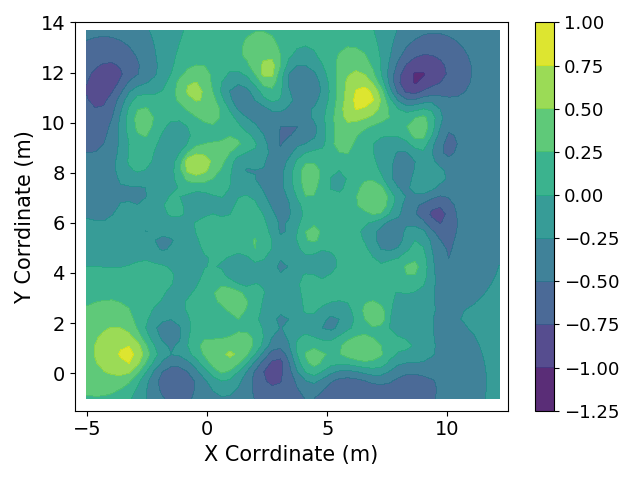

In [29]:
plt.figure()
CS = plt.contourf(PixelCoords[:,0].reshape(nrows, ncols), PixelCoords[:,1].reshape(nrows, ncols), 
                    LossFieldMNE.reshape(nrows, ncols),alpha= 0.9) 
cbar = plt.colorbar(CS) #fraction=0.036, pad=0.04
cbar.ax.tick_params(labelsize=13)
plt.ylabel('Y Corrdinate (m)',fontsize=15) #Loss Field (dB)
plt.xlabel('X Corrdinate (m)',fontsize=15)

plt.xlim([-5.5,12.5])
plt.ylim([-1.5,14])
plt.xticks(fontsize=14,rotation=0)
plt.yticks(fontsize=14,rotation=0)


plt.tight_layout()

### FadLoss vs. FadLossEst

<IPython.core.display.Javascript object>


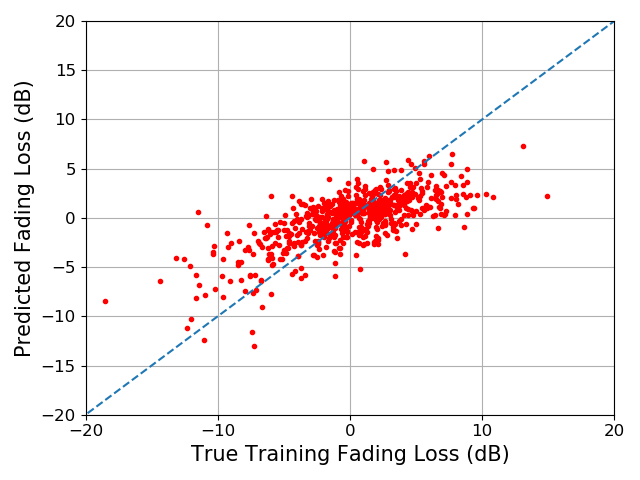

<IPython.core.display.Javascript object>


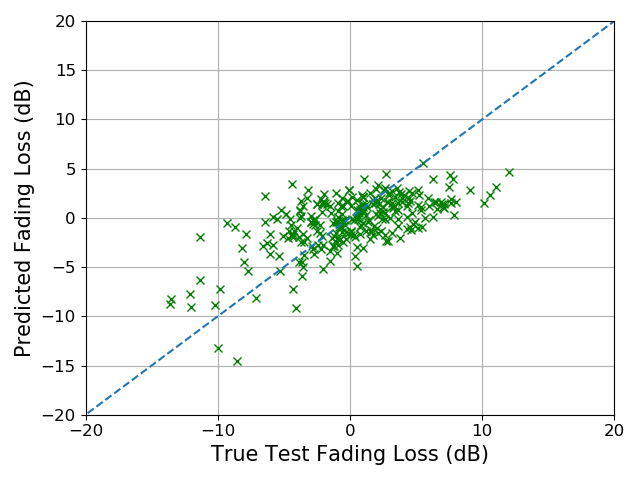

In [38]:
## train
plt.figure()#figsize=(6,4.8)
plt.plot(FadLossTrain, FadLossTrainEst, 'r.')
plt.plot(np.arange(-30,35,5), np.arange(-30,35,5),'--')
plt.ylim([-20,20])
plt.xlim([-20,20])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Predicted Fading Loss (dB)',fontsize=15)
plt.xlabel('True Training Fading Loss (dB)',fontsize=15)
plt.grid()
plt.tight_layout()


## test
plt.figure()#figsize=(6,4.8)
plt.plot(FadLossTest, FadLossTestEst, 'gx')
plt.plot(np.arange(-30,35,5), np.arange(-30,35,5),'--')
plt.ylim([-20,20])
plt.xlim([-20,20])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Predicted Fading Loss (dB)',fontsize=15)
plt.xlabel('True Test Fading Loss (dB)',fontsize=15)
plt.grid()
plt.tight_layout()

